In [1]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

import torchio as tio
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torchio")

from utils.utils import train_3d, validate_3d, validate_3d_patch
from utils.vis import plot_mri
from utils.dataset import BrainMRIDataset
from utils.loss import DiceCrossEntropyLoss, DiceFocalLoss
from models import UNet3D, AttentionUNet
from monai.networks.nets import UNet, SegResNet, UNETR

## Constants

In [2]:
ROOT_DIR = './Data'
BATCH_SIZE = 1
EPOCHS = 300
NUM_CLASSES = 4
NUM_WORKERS=16
DEVICE = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
PATCH_SIZE = 64
QUEUE_LENGTH = 200

## Transforms

In [3]:
# TorchIO transformations for augmentation
train_transform = tio.Compose([
    # tio.RandomAffine(scales=(0.9, 1.1)),
    # tio.RandomElasticDeformation(num_control_points=(7, 7, 7), max_displacement=(4, 4, 4)),
    # tio.RandomFlip(axes=(0, 1, 2)),
    # tio.RandomBiasField(coefficients=(0.1, 0.3)),
    tio.RescaleIntensity((0, 1)),  # Normalize intensity to [0, 1]
    tio.ZNormalization(),
])

val_transform = tio.Compose([
    tio.RescaleIntensity((0, 1)),  # Only normalize intensity for validation
    tio.ZNormalization(),
])

In [4]:
# Create datasets
train_dataset = BrainMRIDataset(os.path.join(ROOT_DIR, 'train'), transform=train_transform)
val_dataset = BrainMRIDataset(os.path.join(ROOT_DIR, 'val'), transform=val_transform)

##################### Training Data Loader #####################
sampler = tio.data.UniformSampler(PATCH_SIZE)

# Queue for training
patches_queue = tio.Queue(
    subjects_dataset=train_dataset,
    max_length=QUEUE_LENGTH,
    samples_per_volume=16,
    sampler=sampler,
    num_workers=0,
    shuffle_subjects=True,
    shuffle_patches=True,
)

# Create DataLoaders
train_loader = tio.SubjectsLoader(patches_queue, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

## Visualization

torch.Size([1, 1, 64, 64, 64]) torch.Size([1, 1, 64, 64, 64])


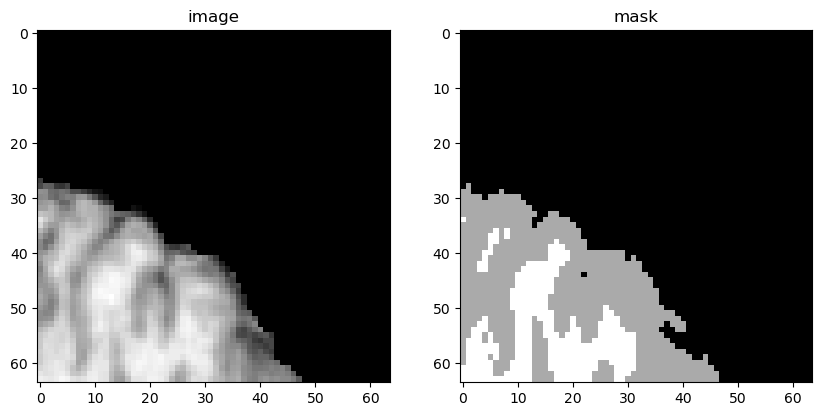

In [6]:
slice_idx = 40
for i, batch in enumerate(train_loader):
    if i == 6:
        images, masks = batch["image"]["data"], batch["mask"]["data"]
        print(images.shape, masks.shape)
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(images[0, 0, :, :, slice_idx].numpy(), cmap='gray')
        axs[0].set_title('image')
        axs[1].imshow(masks[0, 0, :, :, slice_idx].numpy(), cmap='gray')
        axs[1].set_title('mask')
        plt.show()
        break

## Models

In [5]:
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,  
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=4,
    norm="instance",  # Use Instance Normalization
    dropout=0.2       # Add dropout
)
# model = UNETR(in_channels=1, out_channels=4, img_size=(256,128,258), feature_size=32, norm_name='batch')
model = model.to(DEVICE)

## Loss & Optimizer

In [6]:
# class_weights = train_dataset.calculate_class_weights_log(num_classes=4).to(DEVICE)
# criterion = DiceCrossEntropyLoss(dice_weight=1.0, ce_weight=0.0, is_3d=True, class_weights=class_weights)
criterion = DiceFocalLoss(alpha=0.5, gamma=2, is_3d=True, ignore_background=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-7)

## Training

In [9]:
best_avg_dice = 0
for epoch in range(EPOCHS):
    train_avg_loss, train_avg_dice, train_csf_dice, train_gm_dice, train_wm_dice = train_3d(model, train_loader, criterion, optimizer, DEVICE, epoch, EPOCHS, NUM_CLASSES)
    val_loss, val_avg_dice, val_csf_dice, val_gm_dice, val_wm_dice = validate_3d_patch(model, val_dataset, criterion, epoch, EPOCHS, DEVICE, NUM_CLASSES, PATCH_SIZE, BATCH_SIZE, NUM_WORKERS)

    scheduler.step()
    if val_avg_dice > best_avg_dice:
        best_avg_dice = val_avg_dice
        torch.save(model.state_dict(), 'best_model_3d.pth')
        print(f'Best model saved with dice score: {best_avg_dice}\n')

Training Epoch 1/300: 100%|██████████| 160/160 [00:40<00:00,  3.93it/s, Loss=0.0996, Avg Dice=0.516, CSF Dice=5.25e-10, GM Dice=0.774, WM Dice=0.332] 


Epoch 1, Loss: 0.3577
Epoch 1, Dice: 0.5472 CSF Dice: 0.3126 GM Dice: 0.5641 WM Dice: 0.3993


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


Epoch 1/300, Loss: 0.3481, Avg Dice: 0.5328, CSF Dice: 0.0000, GM Dice: 0.7747, WM Dice: 0.3625
Best model saved with dice score: 0.5327752232732511



Training Epoch 2/300: 100%|██████████| 160/160 [00:39<00:00,  4.07it/s, Loss=0.065, Avg Dice=0.682, CSF Dice=0.0415, GM Dice=0.83, WM Dice=0.862]     


Epoch 2, Loss: 0.2965
Epoch 2, Dice: 0.6119 CSF Dice: 0.2396 GM Dice: 0.6954 WM Dice: 0.5681


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 2/300, Loss: 0.3156, Avg Dice: 0.6475, CSF Dice: 0.0035, GM Dice: 0.8232, WM Dice: 0.7681
Best model saved with dice score: 0.6475229666684754



Training Epoch 3/300: 100%|██████████| 160/160 [00:38<00:00,  4.14it/s, Loss=0.061, Avg Dice=0.675, CSF Dice=1.64e-8, GM Dice=0.886, WM Dice=0.816]   


Epoch 3, Loss: 0.2698
Epoch 3, Dice: 0.6200 CSF Dice: 0.1809 GM Dice: 0.7293 WM Dice: 0.6045


100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


Epoch 3/300, Loss: 0.2995, Avg Dice: 0.7018, CSF Dice: 0.1316, GM Dice: 0.8667, WM Dice: 0.8130
Best model saved with dice score: 0.701796866953373



Training Epoch 4/300: 100%|██████████| 160/160 [00:38<00:00,  4.16it/s, Loss=0.114, Avg Dice=0.404, CSF Dice=1.88e-9, GM Dice=0.43, WM Dice=0.19]      


Epoch 4, Loss: 0.2868
Epoch 4, Dice: 0.5656 CSF Dice: 0.0451 GM Dice: 0.6771 WM Dice: 0.6027


100%|██████████| 5/5 [00:14<00:00,  2.98s/it]


Epoch 4/300, Loss: 0.3617, Avg Dice: 0.5410, CSF Dice: 0.0371, GM Dice: 0.5073, WM Dice: 0.6322


Training Epoch 5/300: 100%|██████████| 160/160 [00:39<00:00,  4.01it/s, Loss=0.135, Avg Dice=0.533, CSF Dice=0.0823, GM Dice=0.731, WM Dice=0.816]    


Epoch 5, Loss: 0.2657
Epoch 5, Dice: 0.5860 CSF Dice: 0.0472 GM Dice: 0.7138 WM Dice: 0.6265


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


Epoch 5/300, Loss: 0.3048, Avg Dice: 0.7019, CSF Dice: 0.1887, GM Dice: 0.8215, WM Dice: 0.8016
Best model saved with dice score: 0.7018634304404259



Training Epoch 6/300: 100%|██████████| 160/160 [00:38<00:00,  4.15it/s, Loss=0.0781, Avg Dice=0.588, CSF Dice=1.37e-8, GM Dice=0.864, WM Dice=0.491]  


Epoch 6, Loss: 0.2552
Epoch 6, Dice: 0.6154 CSF Dice: 0.0547 GM Dice: 0.7418 WM Dice: 0.7063


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]


Epoch 6/300, Loss: 0.2924, Avg Dice: 0.7261, CSF Dice: 0.2173, GM Dice: 0.8668, WM Dice: 0.8246
Best model saved with dice score: 0.7260597757995129



Training Epoch 7/300: 100%|██████████| 160/160 [00:39<00:00,  4.08it/s, Loss=0.0988, Avg Dice=0.681, CSF Dice=0.414, GM Dice=0.841, WM Dice=0.754]    


Epoch 7, Loss: 0.2476
Epoch 7, Dice: 0.6270 CSF Dice: 0.0965 GM Dice: 0.7690 WM Dice: 0.6900


100%|██████████| 5/5 [00:18<00:00,  3.67s/it]


Epoch 7/300, Loss: 0.2886, Avg Dice: 0.7343, CSF Dice: 0.2594, GM Dice: 0.8523, WM Dice: 0.8299
Best model saved with dice score: 0.7343444377183914



Training Epoch 8/300: 100%|██████████| 160/160 [00:39<00:00,  4.05it/s, Loss=0.0621, Avg Dice=0.681, CSF Dice=9.09e-8, GM Dice=0.928, WM Dice=0.798]  


Epoch 8, Loss: 0.2669
Epoch 8, Dice: 0.6001 CSF Dice: 0.0928 GM Dice: 0.7062 WM Dice: 0.6601


100%|██████████| 5/5 [00:18<00:00,  3.63s/it]


Epoch 8/300, Loss: 0.2887, Avg Dice: 0.7661, CSF Dice: 0.3697, GM Dice: 0.8656, WM Dice: 0.8336
Best model saved with dice score: 0.7661415413022041



Training Epoch 9/300: 100%|██████████| 160/160 [00:39<00:00,  4.02it/s, Loss=0.0809, Avg Dice=0.513, CSF Dice=1.09e-8, GM Dice=0.915, WM Dice=0.139]   


Epoch 9, Loss: 0.2604
Epoch 9, Dice: 0.6032 CSF Dice: 0.1132 GM Dice: 0.7109 WM Dice: 0.6439


100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


Epoch 9/300, Loss: 0.2892, Avg Dice: 0.7413, CSF Dice: 0.3194, GM Dice: 0.8363, WM Dice: 0.8142


Training Epoch 10/300: 100%|██████████| 160/160 [00:41<00:00,  3.90it/s, Loss=0.0598, Avg Dice=0.686, CSF Dice=4.76e-8, GM Dice=0.898, WM Dice=0.853]  


Epoch 10, Loss: 0.2412
Epoch 10, Dice: 0.6197 CSF Dice: 0.1404 GM Dice: 0.7310 WM Dice: 0.6522


100%|██████████| 5/5 [00:19<00:00,  3.96s/it]


Epoch 10/300, Loss: 0.2862, Avg Dice: 0.7822, CSF Dice: 0.4421, GM Dice: 0.8586, WM Dice: 0.8324
Best model saved with dice score: 0.7821685895323753



Training Epoch 11/300: 100%|██████████| 160/160 [00:40<00:00,  3.91it/s, Loss=0.103, Avg Dice=0.674, CSF Dice=0.303, GM Dice=0.791, WM Dice=0.778]     


Epoch 11, Loss: 0.2381
Epoch 11, Dice: 0.6341 CSF Dice: 0.1448 GM Dice: 0.7571 WM Dice: 0.6832


100%|██████████| 5/5 [00:21<00:00,  4.28s/it]


Epoch 11/300, Loss: 0.2877, Avg Dice: 0.7661, CSF Dice: 0.3594, GM Dice: 0.8683, WM Dice: 0.8411


Training Epoch 12/300: 100%|██████████| 160/160 [00:39<00:00,  4.09it/s, Loss=0.0531, Avg Dice=0.847, CSF Dice=0.723, GM Dice=0.897, WM Dice=0.883]    


Epoch 12, Loss: 0.2298
Epoch 12, Dice: 0.6528 CSF Dice: 0.2063 GM Dice: 0.7627 WM Dice: 0.6894


100%|██████████| 5/5 [00:20<00:00,  4.14s/it]


Epoch 12/300, Loss: 0.2798, Avg Dice: 0.8170, CSF Dice: 0.5648, GM Dice: 0.8630, WM Dice: 0.8450
Best model saved with dice score: 0.8169736564159393



Training Epoch 13/300: 100%|██████████| 160/160 [00:41<00:00,  3.87it/s, Loss=0.158, Avg Dice=0.585, CSF Dice=0.583, GM Dice=0.654, WM Dice=0.786]    


Epoch 13, Loss: 0.2234
Epoch 13, Dice: 0.6520 CSF Dice: 0.1720 GM Dice: 0.7830 WM Dice: 0.6877


100%|██████████| 5/5 [00:21<00:00,  4.32s/it]


Epoch 13/300, Loss: 0.2780, Avg Dice: 0.8237, CSF Dice: 0.5726, GM Dice: 0.8801, WM Dice: 0.8462
Best model saved with dice score: 0.8237110376358032



Training Epoch 14/300: 100%|██████████| 160/160 [00:39<00:00,  4.08it/s, Loss=0.0567, Avg Dice=0.7, CSF Dice=1.19e-8, GM Dice=0.926, WM Dice=0.876]   


Epoch 14, Loss: 0.2311
Epoch 14, Dice: 0.6601 CSF Dice: 0.2671 GM Dice: 0.7490 WM Dice: 0.6587


100%|██████████| 5/5 [00:20<00:00,  4.19s/it]


Epoch 14/300, Loss: 0.2795, Avg Dice: 0.8218, CSF Dice: 0.5762, GM Dice: 0.8742, WM Dice: 0.8409


Training Epoch 15/300: 100%|██████████| 160/160 [00:39<00:00,  4.04it/s, Loss=0.0601, Avg Dice=0.755, CSF Dice=0.352, GM Dice=0.846, WM Dice=0.846]   


Epoch 15, Loss: 0.2415
Epoch 15, Dice: 0.6504 CSF Dice: 0.2371 GM Dice: 0.7674 WM Dice: 0.6527


100%|██████████| 5/5 [00:20<00:00,  4.18s/it]


Epoch 15/300, Loss: 0.2846, Avg Dice: 0.7975, CSF Dice: 0.4766, GM Dice: 0.8719, WM Dice: 0.8462


Training Epoch 16/300: 100%|██████████| 160/160 [00:38<00:00,  4.17it/s, Loss=0.048, Avg Dice=0.779, CSF Dice=0.464, GM Dice=0.838, WM Dice=0.823]    


Epoch 16, Loss: 0.2179
Epoch 16, Dice: 0.6750 CSF Dice: 0.2134 GM Dice: 0.7873 WM Dice: 0.7255


100%|██████████| 5/5 [00:21<00:00,  4.22s/it]


Epoch 16/300, Loss: 0.2774, Avg Dice: 0.8375, CSF Dice: 0.6266, GM Dice: 0.8791, WM Dice: 0.8482
Best model saved with dice score: 0.8375024646520615



Training Epoch 17/300: 100%|██████████| 160/160 [00:41<00:00,  3.85it/s, Loss=0.063, Avg Dice=0.638, CSF Dice=3.33e-7, GM Dice=0.868, WM Dice=0.683]  


Epoch 17, Loss: 0.2182
Epoch 17, Dice: 0.6667 CSF Dice: 0.2638 GM Dice: 0.7575 WM Dice: 0.6790


100%|██████████| 5/5 [00:26<00:00,  5.38s/it]


Epoch 17/300, Loss: 0.2755, Avg Dice: 0.8326, CSF Dice: 0.6297, GM Dice: 0.8625, WM Dice: 0.8419


Training Epoch 18/300: 100%|██████████| 160/160 [00:45<00:00,  3.54it/s, Loss=0.0792, Avg Dice=0.604, CSF Dice=9.9e-9, GM Dice=0.762, WM Dice=0.666]  


Epoch 18, Loss: 0.2114
Epoch 18, Dice: 0.7101 CSF Dice: 0.3679 GM Dice: 0.8009 WM Dice: 0.6956


100%|██████████| 5/5 [00:24<00:00,  4.89s/it]


Epoch 18/300, Loss: 0.2860, Avg Dice: 0.8141, CSF Dice: 0.5852, GM Dice: 0.8571, WM Dice: 0.8194


Training Epoch 19/300: 100%|██████████| 160/160 [00:48<00:00,  3.29it/s, Loss=0.058, Avg Dice=0.691, CSF Dice=3.33e-7, GM Dice=0.921, WM Dice=0.85]   


Epoch 19, Loss: 0.2294
Epoch 19, Dice: 0.6614 CSF Dice: 0.2305 GM Dice: 0.7975 WM Dice: 0.6548


100%|██████████| 5/5 [00:28<00:00,  5.69s/it]


Epoch 19/300, Loss: 0.2767, Avg Dice: 0.8282, CSF Dice: 0.6011, GM Dice: 0.8793, WM Dice: 0.8367


Training Epoch 20/300: 100%|██████████| 160/160 [00:47<00:00,  3.34it/s, Loss=0.158, Avg Dice=0.553, CSF Dice=0.233, GM Dice=0.78, WM Dice=0.802]     


Epoch 20, Loss: 0.2239
Epoch 20, Dice: 0.6763 CSF Dice: 0.2410 GM Dice: 0.7816 WM Dice: 0.7182


100%|██████████| 5/5 [00:26<00:00,  5.33s/it]


Epoch 20/300, Loss: 0.2718, Avg Dice: 0.8520, CSF Dice: 0.6745, GM Dice: 0.8848, WM Dice: 0.8525
Best model saved with dice score: 0.8519794642925262



Training Epoch 21/300: 100%|██████████| 160/160 [00:51<00:00,  3.12it/s, Loss=0.0859, Avg Dice=0.492, CSF Dice=1e-6, GM Dice=0.93, WM Dice=0.0399]     


Epoch 21, Loss: 0.2077
Epoch 21, Dice: 0.7292 CSF Dice: 0.3859 GM Dice: 0.8169 WM Dice: 0.7280


100%|██████████| 5/5 [00:27<00:00,  5.57s/it]


Epoch 21/300, Loss: 0.2762, Avg Dice: 0.8168, CSF Dice: 0.5495, GM Dice: 0.8717, WM Dice: 0.8500


Training Epoch 22/300: 100%|██████████| 160/160 [00:45<00:00,  3.50it/s, Loss=0.0555, Avg Dice=0.776, CSF Dice=0.539, GM Dice=0.825, WM Dice=0.76]     


Epoch 22, Loss: 0.2048
Epoch 22, Dice: 0.7508 CSF Dice: 0.4864 GM Dice: 0.8396 WM Dice: 0.7128


100%|██████████| 5/5 [00:29<00:00,  5.88s/it]


Epoch 22/300, Loss: 0.2766, Avg Dice: 0.8396, CSF Dice: 0.6256, GM Dice: 0.8824, WM Dice: 0.8545


Training Epoch 23/300: 100%|██████████| 160/160 [00:52<00:00,  3.04it/s, Loss=0.0517, Avg Dice=0.814, CSF Dice=0.603, GM Dice=0.87, WM Dice=0.816]     


Epoch 23, Loss: 0.2148
Epoch 23, Dice: 0.6986 CSF Dice: 0.3282 GM Dice: 0.7947 WM Dice: 0.7063


100%|██████████| 5/5 [00:26<00:00,  5.28s/it]


Epoch 23/300, Loss: 0.2734, Avg Dice: 0.8447, CSF Dice: 0.6477, GM Dice: 0.8823, WM Dice: 0.8527


Training Epoch 24/300: 100%|██████████| 160/160 [00:42<00:00,  3.77it/s, Loss=0.0323, Avg Dice=0.871, CSF Dice=0.749, GM Dice=0.877, WM Dice=0.871]    


Epoch 24, Loss: 0.2223
Epoch 24, Dice: 0.6663 CSF Dice: 0.2680 GM Dice: 0.7727 WM Dice: 0.6700


100%|██████████| 5/5 [00:23<00:00,  4.64s/it]


Epoch 24/300, Loss: 0.2742, Avg Dice: 0.8446, CSF Dice: 0.6524, GM Dice: 0.8830, WM Dice: 0.8469


Training Epoch 25/300: 100%|██████████| 160/160 [00:41<00:00,  3.82it/s, Loss=0.0606, Avg Dice=0.681, CSF Dice=2.63e-8, GM Dice=0.925, WM Dice=0.804]


Epoch 25, Loss: 0.2091
Epoch 25, Dice: 0.7024 CSF Dice: 0.3342 GM Dice: 0.8005 WM Dice: 0.7106


100%|██████████| 5/5 [00:23<00:00,  4.74s/it]


Epoch 25/300, Loss: 0.2729, Avg Dice: 0.8520, CSF Dice: 0.6749, GM Dice: 0.8857, WM Dice: 0.8514
Best model saved with dice score: 0.8520120829343796



Training Epoch 26/300: 100%|██████████| 160/160 [00:42<00:00,  3.78it/s, Loss=0.0912, Avg Dice=0.462, CSF Dice=2e-7, GM Dice=0.851, WM Dice=5.35e-9]  


Epoch 26, Loss: 0.2384
Epoch 26, Dice: 0.6585 CSF Dice: 0.2867 GM Dice: 0.7404 WM Dice: 0.6500


100%|██████████| 5/5 [00:24<00:00,  4.82s/it]


Epoch 26/300, Loss: 0.2723, Avg Dice: 0.8512, CSF Dice: 0.6812, GM Dice: 0.8780, WM Dice: 0.8496


Training Epoch 27/300: 100%|██████████| 160/160 [00:41<00:00,  3.83it/s, Loss=0.0704, Avg Dice=0.771, CSF Dice=0.422, GM Dice=0.837, WM Dice=0.897]    


Epoch 27, Loss: 0.2095
Epoch 27, Dice: 0.6873 CSF Dice: 0.2614 GM Dice: 0.8046 WM Dice: 0.7230


100%|██████████| 5/5 [00:25<00:00,  5.16s/it]


Epoch 27/300, Loss: 0.2745, Avg Dice: 0.8455, CSF Dice: 0.6672, GM Dice: 0.8711, WM Dice: 0.8480


Training Epoch 28/300: 100%|██████████| 160/160 [00:42<00:00,  3.80it/s, Loss=0.0629, Avg Dice=0.674, CSF Dice=1.55e-9, GM Dice=0.845, WM Dice=0.863] 


Epoch 28, Loss: 0.2105
Epoch 28, Dice: 0.7228 CSF Dice: 0.4049 GM Dice: 0.7881 WM Dice: 0.7369


100%|██████████| 5/5 [00:27<00:00,  5.43s/it]


Epoch 28/300, Loss: 0.2706, Avg Dice: 0.8425, CSF Dice: 0.6378, GM Dice: 0.8802, WM Dice: 0.8562


Training Epoch 29/300: 100%|██████████| 160/160 [00:44<00:00,  3.58it/s, Loss=0.039, Avg Dice=0.848, CSF Dice=0.566, GM Dice=0.912, WM Dice=0.94]    


Epoch 29, Loss: 0.2058
Epoch 29, Dice: 0.7159 CSF Dice: 0.3994 GM Dice: 0.7993 WM Dice: 0.7106


100%|██████████| 5/5 [00:27<00:00,  5.41s/it]


Epoch 29/300, Loss: 0.2790, Avg Dice: 0.8334, CSF Dice: 0.6091, GM Dice: 0.8755, WM Dice: 0.8532


Training Epoch 30/300: 100%|██████████| 160/160 [00:42<00:00,  3.79it/s, Loss=0.0805, Avg Dice=0.634, CSF Dice=3.75e-9, GM Dice=0.835, WM Dice=0.718] 


Epoch 30, Loss: 0.2149
Epoch 30, Dice: 0.7171 CSF Dice: 0.4171 GM Dice: 0.8071 WM Dice: 0.6761


100%|██████████| 5/5 [00:28<00:00,  5.77s/it]


Epoch 30/300, Loss: 0.2720, Avg Dice: 0.8359, CSF Dice: 0.6659, GM Dice: 0.8488, WM Dice: 0.8328


Training Epoch 31/300: 100%|██████████| 160/160 [00:43<00:00,  3.70it/s, Loss=0.0675, Avg Dice=0.67, CSF Dice=9.84e-10, GM Dice=0.841, WM Dice=0.859]


Epoch 31, Loss: 0.2065
Epoch 31, Dice: 0.7224 CSF Dice: 0.3666 GM Dice: 0.8146 WM Dice: 0.7430


100%|██████████| 5/5 [00:28<00:00,  5.78s/it]


Epoch 31/300, Loss: 0.2704, Avg Dice: 0.8496, CSF Dice: 0.6939, GM Dice: 0.8619, WM Dice: 0.8468


Training Epoch 32/300: 100%|██████████| 160/160 [00:43<00:00,  3.65it/s, Loss=0.0692, Avg Dice=0.769, CSF Dice=0.561, GM Dice=0.789, WM Dice=0.789]    


Epoch 32, Loss: 0.2119
Epoch 32, Dice: 0.7518 CSF Dice: 0.5248 GM Dice: 0.8005 WM Dice: 0.7092


100%|██████████| 5/5 [00:29<00:00,  5.82s/it]


Epoch 32/300, Loss: 0.2674, Avg Dice: 0.8657, CSF Dice: 0.7149, GM Dice: 0.8868, WM Dice: 0.8649
Best model saved with dice score: 0.8656808286905289



Training Epoch 33/300: 100%|██████████| 160/160 [00:45<00:00,  3.55it/s, Loss=0.0279, Avg Dice=0.907, CSF Dice=0.85, GM Dice=0.908, WM Dice=0.882]   


Epoch 33, Loss: 0.1957
Epoch 33, Dice: 0.7586 CSF Dice: 0.4984 GM Dice: 0.8224 WM Dice: 0.7492


100%|██████████| 5/5 [00:22<00:00,  4.49s/it]


Epoch 33/300, Loss: 0.2728, Avg Dice: 0.8615, CSF Dice: 0.7090, GM Dice: 0.8844, WM Dice: 0.8570


Training Epoch 34/300: 100%|██████████| 160/160 [00:38<00:00,  4.11it/s, Loss=0.125, Avg Dice=0.5, CSF Dice=8.33e-8, GM Dice=8.33e-8, WM Dice=1]       


Epoch 34, Loss: 0.2020
Epoch 34, Dice: 0.7202 CSF Dice: 0.3926 GM Dice: 0.8060 WM Dice: 0.7215


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]


Epoch 34/300, Loss: 0.2751, Avg Dice: 0.8413, CSF Dice: 0.6879, GM Dice: 0.8511, WM Dice: 0.8301


Training Epoch 35/300: 100%|██████████| 160/160 [00:38<00:00,  4.15it/s, Loss=0.0572, Avg Dice=0.935, CSF Dice=1, GM Dice=0.944, WM Dice=0.8]        


Epoch 35, Loss: 0.2126
Epoch 35, Dice: 0.7400 CSF Dice: 0.4369 GM Dice: 0.7972 WM Dice: 0.7522


100%|██████████| 5/5 [00:17<00:00,  3.45s/it]


Epoch 35/300, Loss: 0.2673, Avg Dice: 0.8740, CSF Dice: 0.7477, GM Dice: 0.8883, WM Dice: 0.8638
Best model saved with dice score: 0.8740114718675613



Training Epoch 36/300: 100%|██████████| 160/160 [00:40<00:00,  3.91it/s, Loss=0.0464, Avg Dice=0.817, CSF Dice=0.699, GM Dice=0.816, WM Dice=0.77]     


Epoch 36, Loss: 0.2029
Epoch 36, Dice: 0.7313 CSF Dice: 0.4293 GM Dice: 0.8172 WM Dice: 0.7072


100%|██████████| 5/5 [00:16<00:00,  3.37s/it]


Epoch 36/300, Loss: 0.2726, Avg Dice: 0.8609, CSF Dice: 0.7173, GM Dice: 0.8731, WM Dice: 0.8573


Training Epoch 37/300: 100%|██████████| 160/160 [00:41<00:00,  3.90it/s, Loss=0.0576, Avg Dice=0.788, CSF Dice=0.607, GM Dice=0.794, WM Dice=0.79]   


Epoch 37, Loss: 0.2023
Epoch 37, Dice: 0.7339 CSF Dice: 0.4250 GM Dice: 0.8023 WM Dice: 0.7377


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 37/300, Loss: 0.2689, Avg Dice: 0.8490, CSF Dice: 0.6712, GM Dice: 0.8699, WM Dice: 0.8590


Training Epoch 38/300: 100%|██████████| 160/160 [00:39<00:00,  4.03it/s, Loss=0.0712, Avg Dice=0.586, CSF Dice=9.9e-9, GM Dice=0.798, WM Dice=0.549] 


Epoch 38, Loss: 0.2011
Epoch 38, Dice: 0.7412 CSF Dice: 0.4692 GM Dice: 0.8127 WM Dice: 0.7094


100%|██████████| 5/5 [00:17<00:00,  3.56s/it]


Epoch 38/300, Loss: 0.2679, Avg Dice: 0.8767, CSF Dice: 0.7575, GM Dice: 0.8882, WM Dice: 0.8649
Best model saved with dice score: 0.8767173886299133



Training Epoch 39/300: 100%|██████████| 160/160 [00:40<00:00,  3.91it/s, Loss=0.0599, Avg Dice=0.657, CSF Dice=2.78e-8, GM Dice=0.873, WM Dice=0.758] 


Epoch 39, Loss: 0.2093
Epoch 39, Dice: 0.6961 CSF Dice: 0.3633 GM Dice: 0.7731 WM Dice: 0.6837


100%|██████████| 5/5 [00:18<00:00,  3.74s/it]


Epoch 39/300, Loss: 0.2710, Avg Dice: 0.8669, CSF Dice: 0.7389, GM Dice: 0.8771, WM Dice: 0.8551


Training Epoch 40/300: 100%|██████████| 160/160 [00:39<00:00,  4.03it/s, Loss=0.0303, Avg Dice=0.9, CSF Dice=0.834, GM Dice=0.925, WM Dice=0.86]     


Epoch 40, Loss: 0.2046
Epoch 40, Dice: 0.7423 CSF Dice: 0.4690 GM Dice: 0.7864 WM Dice: 0.7504


100%|██████████| 5/5 [00:18<00:00,  3.61s/it]


Epoch 40/300, Loss: 0.2657, Avg Dice: 0.8714, CSF Dice: 0.7536, GM Dice: 0.8765, WM Dice: 0.8595


Training Epoch 41/300: 100%|██████████| 160/160 [00:40<00:00,  3.91it/s, Loss=0.0676, Avg Dice=0.644, CSF Dice=1.64e-8, GM Dice=0.907, WM Dice=0.678]


Epoch 41, Loss: 0.2003
Epoch 41, Dice: 0.7505 CSF Dice: 0.4951 GM Dice: 0.8286 WM Dice: 0.6995


100%|██████████| 5/5 [00:19<00:00,  3.83s/it]


Epoch 41/300, Loss: 0.2689, Avg Dice: 0.8675, CSF Dice: 0.7212, GM Dice: 0.8859, WM Dice: 0.8669


Training Epoch 42/300: 100%|██████████| 160/160 [00:39<00:00,  4.01it/s, Loss=0.0885, Avg Dice=0.733, CSF Dice=1, GM Dice=0.806, WM Dice=0.128]       


Epoch 42, Loss: 0.2015
Epoch 42, Dice: 0.7527 CSF Dice: 0.4641 GM Dice: 0.8105 WM Dice: 0.7622


100%|██████████| 5/5 [00:18<00:00,  3.72s/it]


Epoch 42/300, Loss: 0.2670, Avg Dice: 0.8716, CSF Dice: 0.7314, GM Dice: 0.8937, WM Dice: 0.8649


Training Epoch 43/300: 100%|██████████| 160/160 [00:40<00:00,  3.94it/s, Loss=0.0507, Avg Dice=0.837, CSF Dice=0.738, GM Dice=0.847, WM Dice=0.831]  


Epoch 43, Loss: 0.1914
Epoch 43, Dice: 0.7673 CSF Dice: 0.5397 GM Dice: 0.8310 WM Dice: 0.7238


100%|██████████| 5/5 [00:19<00:00,  3.90s/it]


Epoch 43/300, Loss: 0.2620, Avg Dice: 0.8803, CSF Dice: 0.7826, GM Dice: 0.8792, WM Dice: 0.8630
Best model saved with dice score: 0.880263552069664



Training Epoch 44/300: 100%|██████████| 160/160 [00:38<00:00,  4.12it/s, Loss=0.0834, Avg Dice=0.53, CSF Dice=1e-6, GM Dice=0.907, WM Dice=0.214]      


Epoch 44, Loss: 0.2008
Epoch 44, Dice: 0.7488 CSF Dice: 0.4910 GM Dice: 0.8038 WM Dice: 0.7412


100%|██████████| 5/5 [00:19<00:00,  3.95s/it]


Epoch 44/300, Loss: 0.2694, Avg Dice: 0.8671, CSF Dice: 0.7405, GM Dice: 0.8740, WM Dice: 0.8579


Training Epoch 45/300: 100%|██████████| 160/160 [00:41<00:00,  3.82it/s, Loss=0.114, Avg Dice=0.581, CSF Dice=1e-6, GM Dice=0.326, WM Dice=1]        


Epoch 45, Loss: 0.2091
Epoch 45, Dice: 0.7420 CSF Dice: 0.4624 GM Dice: 0.8158 WM Dice: 0.7135


100%|██████████| 5/5 [00:21<00:00,  4.35s/it]


Epoch 45/300, Loss: 0.2611, Avg Dice: 0.8886, CSF Dice: 0.7947, GM Dice: 0.8926, WM Dice: 0.8708
Best model saved with dice score: 0.888566255569458



Training Epoch 46/300:   0%|          | 0/160 [00:00<?, ?it/s]